In [1]:
import os
# Required to suppress tensorflow annoying warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data processing
import pandas as pd
import numpy as np

# Language Models
import spacy
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Regex
import re


In [3]:
# Get scraped data
df = pd.read_csv("./data/output.csv")

### Data Cleaning

In [4]:
# "review_text" nan are to be deleted. Other can stay.
df = df.dropna(subset=["review_text"])

# Remove invalid entries
df = df.loc[df["entry_date"] != "entry_date"]

# Remove duplicate entries
df = df.drop_duplicates(["offer_ref", "entry_id", "review_text"]).drop_duplicates("review_text")


In [5]:
# fix data types
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["entry_id"] = df["entry_id"].astype(int)
df["offer_ref"] = df["offer_ref"].astype(int)
df["score"] = df["score"].astype(float)

In [6]:
# Get Sentiment Cases based on score
df["sentiment"] = df["score"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

In [7]:
# Remove new_lines and get rid of unnecceary spaces
df["review_text"] = df["review_text"].replace("\n", " ", regex=True).replace("_+", " ", regex=True)

### Training Data Prep

In [8]:
# Get data to train the model on.
data_cleaned = df[["review_text", "sentiment"]].reset_index(drop=True).copy()

In [82]:
# Crude way of replacing all ok's
data_cleaned["review_text"] = data_cleaned["review_text"].replace("ok", "OK", regex=True)

In [2]:
# Get Language Model
nlp = spacy.load("pl_core_news_lg")
spacy.lang.pl.stop_words.STOP_WORDS.remove("ok")
spacy.lang.pl.stop_words.STOP_WORDS.remove("nie")


In [3]:
# Load Word2Vec Model
gensim_model_file_path = "./gensim models/cbow.v300.m8.hs.mwe.w2v.gensim"
gensim_model = gensim.models.KeyedVectors.load(gensim_model_file_path)

### Despite Above Wrangling: Data from data_cleaning script will be used down here. 

In [4]:
# Target
sentiment_provision = pd.read_csv("sentiment provision.csv")

# Testing Typo fixing
df_no_fix = pd.read_csv("Comparison to a Typo fix.csv")

df_typo_fix = pd.read_csv("Testing Typo Checking.csv")

# Join Target with data
df_no_fix = pd.merge(sentiment_provision, df_no_fix, how="right", on="Unnamed: 0")
df_typo_fix = pd.merge(sentiment_provision, df_typo_fix, how="right", on="Unnamed: 0")

In [5]:
# TODO Temporary
# Join tokenized data and then turn space+punctuation into punctuation
df_typo_fix["review_text"] = (df_typo_fix["review_text"]
                              .transform(lambda x: " ".join(x[1:-1].split(", ")))
                              .transform(lambda x: re.sub("( )([\.,])", lambda match: match.group(2), re.sub("'", "", x))))

In [6]:
# Dropna
df_no_fix = df_no_fix.dropna(subset=["review_text", "sentiment"])
df_typo_fix = df_typo_fix.dropna(subset=["review_text", "sentiment"])

In [7]:
# Tokenization on cleaned data
df_no_fix["review_text"] = df_no_fix["review_text"].transform(nlp)
df_typo_fix["review_text"] = df_typo_fix["review_text"].transform(nlp)

In [8]:
# Apply tokenizer to uncleaned data (TAKES ROUGHLY 5 mins!!! on 40K reviews)
# data_cleaned["review_text"] = data_cleaned["review_text"].transform(lambda x: nlp(x))

In [9]:
df_typo_fix["vectored_form"] = (
    df_typo_fix["review_text"]
        .transform(lambda x: [[token.vector for token in sentence 
                                if (not token.is_punct) and (not token.is_stop)] 
                                for sentence in x.sents])
        .transform(lambda x: tf.convert_to_tensor(
            [tf.concat([tf.reduce_mean(sentence, 0),
                        tf.reduce_max(sentence, 0)], axis=0) 
                        for sentence in x if len(sentence) > 0]))
)

In [10]:
df_typo_fix["vectored_form_gensim"] = (
    df_typo_fix["review_text"]
        .transform(lambda x: [
            [gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) 
             else np.zeros(300, dtype=np.float32) for token in sentence 
             if (not token.is_punct) 
                 and (not token.is_stop)]
             for sentence in x.sents])
        .transform(lambda x: tf.convert_to_tensor(
            [tf.concat([tf.reduce_mean(sentence, 0), 
                        tf.reduce_max(sentence, 0)], axis=0) 
                        for sentence in x if len(sentence) > 0]))
)

In [11]:
# data_cleaned["vectored_form"] = (
#     data_cleaned["review_text"]
#         .transform(lambda x: [[token.vector for token in sentence 
#                                 if (not token.is_punct) and (not token.is_stop)]
#                                 for sentence in x.sents])
#         .transform(lambda x: tf.convert_to_tensor(
#             [tf.concat([tf.reduce_mean(sentence, 0), 
#                         tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))
# )

# data_cleaned["vectored_form_gensim"] = (
#     data_cleaned["review_text"]
#         .transform(lambda x: [
#             [gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) 
#              else np.zeros(300, dtype=np.float32) for token in sentence 
#              if (not token.is_punct) 
#                  and (not token.is_stop)]
#              for sentence in x.sents])
#         .transform(lambda x: tf.convert_to_tensor(
#             [tf.concat([tf.reduce_mean(sentence, 0), 
#                         tf.reduce_max(sentence, 0)], axis=0) 
#                         for sentence in x if len(sentence) > 0]))
# )

# Prepare target for categorical crossentropy
# data_cleaned["target"] = data_cleaned["sentiment"].transform(lambda x: 1 if x == "Positive" else 0)

# # Cleaning Empty sentences.
# data_cleaned = data_cleaned[
#     data_cleaned["review_text"]
#         .transform(lambda x: 
#                    [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 
#                      for token in sentence 
#                      if (not token.is_punct) and (not token.is_stop)] 
#                      for sentence in x.sents])
#         .transform(lambda x: [sentence for sentence in x if len(sentence) > 0])
#         .transform(lambda x: len(x)) != 0]

In [12]:
# Prepare target for categorical crossentropy
# df_no_fix["target"] = df_no_fix["sentiment"].transform(lambda x: 1 if x == "Positive" else 0) 
df_typo_fix["target"] = df_typo_fix["sentiment"].transform(lambda x: 1 if x == "Positive" else 0)

In [13]:
# df_no_fix = df_no_fix[
#     df_no_fix["review_text"]
#         .transform(lambda x: 
#                    [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 
#                      for token in sentence 
#                      if (not token.is_punct) and (not token.is_stop)] 
#                      for sentence in x.sents])
#         .transform(lambda x: [sentence for sentence in x if len(sentence) > 0])
#         .transform(lambda x: len(x)) != 0].copy()

# df_typo_fix = df_typo_fix[
#     df_typo_fix["review_text"]
#         .transform(lambda x: 
#                    [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 
#                      for token in sentence 
#                      if (not token.is_punct) and (not token.is_stop)] 
#                      for sentence in x.sents])
#         .transform(lambda x: [sentence for sentence in x if len(sentence) > 0])
#         .transform(lambda x: len(x)) != 0].copy()

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] 
        batch_x = tf.convert_to_tensor([tf.pad(x, [[0, 83 - x.shape[0]], [0, 0]]) for x in batch_x])
        batch_y = tf.convert_to_tensor(self.y[idx * self.batch_size:(idx + 1) * self.batch_size])
        return batch_x, batch_y

In [15]:
df_typo_fix["shape"] = df_typo_fix["vectored_form"].transform(lambda x: x.shape)

In [16]:
df_typo_fix = df_typo_fix[df_typo_fix["shape"].transform(lambda x: len(x)) != 1]

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_typo_fix.loc[df_typo_fix["sentiment"].isin(["Positive", "Negative"]), "vectored_form"], 
    df_typo_fix.loc[df_typo_fix["sentiment"].isin(["Positive", "Negative"]),"target"], 
    test_size=0.2, 
    random_state=42
)

# Further split to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

train_gen = DataGenerator(X_train, y_train, 1800)
val_gen = DataGenerator(X_val, y_val, 1800)
test_gen = DataGenerator(X_test, y_test, 1800)

In [24]:


# Clear session
keras.backend.clear_session()

# model initialization
model = keras.Sequential([
    keras.layers.Dropout(0.1, input_shape=(83, 600)),
    keras.layers.Bidirectional(keras.layers.LSTM(256)),
    keras.layers.Dropout(0.2, ),
    keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model with loss suited for 2 categories: "Positive", "Negative"
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'],
)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 83, 600)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1755136   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,763,361
Trainable params: 1,763,361
Non-trainable params: 0
______________________________________________

In [25]:
# Fit Model and save history
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
 2/19 [==>...........................] - ETA: 2s - loss: 0.6930 - accuracy: 0.5363  

: 

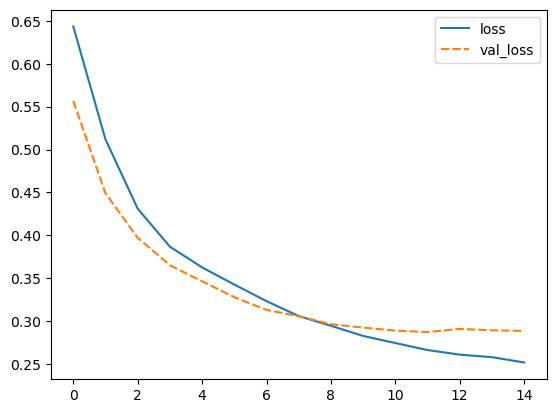

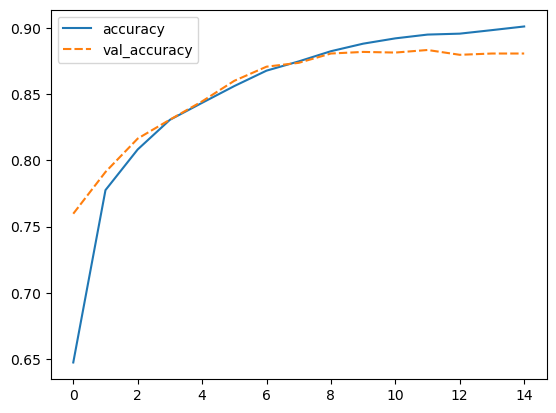

In [ ]:
# plot loss history using seaborn

sns.lineplot(data=pd.DataFrame(history.history)[["loss", "val_loss"]])
plt.show()

# plot accuracy history using seaborn
sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "val_accuracy"]])
plt.show()

In [ ]:
model.evaluate(test_gen)

6/6 [==============================] - 2s 335ms/step - loss: 0.2529 - accuracy: 0.8997


[0.25286972522735596, 0.8997187614440918]